# HoloViewsとPanelのインタラクティブ可視化チュートリアル

このノートブックでは、HoloViewsとPanelを使用した高度なインタラクティブデータ可視化を学びます。

## 目次
1. HoloViewsとPanelの基礎
2. 経済物理学への応用：市場ダイナミクス
3. ネットワーク科学への応用：動的ネットワーク

## インストール

必要なライブラリをインストールします：

In [7]:
# 必要なライブラリのインストール
# !pip install holoviews panel pandas numpy networkx bokeh

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
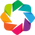

In [8]:
import numpy as np
import pandas as pd
import holoviews as hv
import panel as pn
import networkx as nx
from holoviews import opts

# HoloViewsの拡張機能を有効化
hv.extension('bokeh')
pn.extension()

## 1. HoloViewsとPanelの基礎

### HoloViewsの基本要素

HoloViewsは、データを高レベルで記述し、宣言的に可視化するライブラリです。

In [9]:
# サンプルデータの作成
x = np.linspace(0, 4*np.pi, 100)
y = np.sin(x)

# HoloViewsのCurveオブジェクト
curve = hv.Curve((x, y), 'x', 'sin(x)')

# スタイリング
curve.opts(
    width=600, 
    height=400, 
    color='blue', 
    line_width=2,
    title='正弦波'
)

:Curve   [x]   (sin(x))

In [10]:
# 複数のプロットを組み合わせる
cos_curve = hv.Curve((x, np.cos(x)), 'x', 'cos(x)').opts(color='red', line_width=2)
tan_curve = hv.Curve((x[:80], np.tan(x[:80])), 'x', 'tan(x)').opts(color='green', line_width=2)

# オーバーレイ
overlay = (curve * cos_curve).opts(
    width=600,
    height=400,
    title='三角関数のオーバーレイ',
    legend_position='top_right'
)

overlay

:Overlay
   .Curve.I  :Curve   [x]   (sin(x))
   .Curve.II :Curve   [x]   (cos(x))

In [11]:
# レイアウト
layout = (curve + cos_curve).opts(
    opts.Curve(width=350, height=300)
)

layout

:Layout
   .Curve.I  :Curve   [x]   (sin(x))
   .Curve.II :Curve   [x]   (cos(x))

### HoloMapによる多次元データの可視化

HoloMapを使用すると、パラメータを変化させながらデータを探索できます。

In [12]:
# 周波数と位相をパラメータとした波
def sine_wave(phase, frequency):
    x = np.linspace(0, 4*np.pi, 100)
    y = np.sin(frequency * x + phase)
    return hv.Curve((x, y), 'x', 'y')

# パラメータ空間の定義
phases = np.linspace(0, 2*np.pi, 11)
frequencies = [0.5, 1.0, 1.5, 2.0]

# HoloMapの作成
holomap = hv.HoloMap(
    {(p, f): sine_wave(p, f) for p in phases for f in frequencies},
    kdims=['位相', '周波数']
)

holomap.opts(
    width=600,
    height=400,
    title='位相と周波数の探索'
)

:HoloMap   [位相,周波数]
   :Curve   [x]   (y)

### DynamicMapによる動的な可視化

DynamicMapは、パラメータに応じて動的にプロットを生成します。

In [13]:
def parametric_curve(amplitude=1.0, frequency=1.0, phase=0.0):
    x = np.linspace(0, 4*np.pi, 200)
    y = amplitude * np.sin(frequency * x + phase)
    return hv.Curve((x, y), 'x', 'y')

# DynamicMapの作成
dmap = hv.DynamicMap(parametric_curve, kdims=['amplitude', 'frequency', 'phase'])

# パラメータ範囲の設定
dmap = dmap.redim.range(amplitude=(0.1, 3.0), frequency=(0.1, 5.0), phase=(0, 2*np.pi))

dmap.opts(
    width=700,
    height=400,
    title='パラメトリック曲線'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'48fc1271-5441-4a8f-bca2-33e7c51f87d6': {'version…

## 2. 経済物理学への応用：市場ダイナミクス

経済物理学では、複雑系の視点から市場を分析します。
ここでは、エージェントベースモデルと相関構造を可視化します。

In [ ]:
# オーンスタイン＝ウーレンベック過程による価格生成
def ornstein_uhlenbeck(mu, theta, sigma, dt, n_steps, S0=100):
    """
    平均回帰性を持つ価格過程
    mu: 長期平均
    theta: 回帰速度
    sigma: ボラティリティ
    """
    prices = np.zeros(n_steps)
    prices[0] = S0
    
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dS = theta * (mu - prices[t-1]) * dt + sigma * prices[t-1] * dW
        prices[t] = prices[t-1] + dS
    
    return prices

# 複数の資産の生成（相関あり）
def generate_correlated_assets(n_assets=5, n_steps=252, correlation=0.3):
    """
    相関のある複数資産の価格を生成
    """
    # 相関行列の作成
    corr_matrix = np.ones((n_assets, n_assets)) * correlation
    np.fill_diagonal(corr_matrix, 1.0)
    
    # コレスキー分解
    L = np.linalg.cholesky(corr_matrix)
    
    # 独立な乱数を生成
    independent_returns = np.random.randn(n_steps, n_assets) * 0.02
    
    # 相関を持たせる
    correlated_returns = independent_returns @ L.T
    
    # 価格に変換
    prices = 100 * np.exp(np.cumsum(correlated_returns, axis=0))
    
    return prices

# データの生成
n_assets = 5
n_steps = 252
prices = generate_correlated_assets(n_assets, n_steps)

dates = pd.date_range('2023-01-01', periods=n_steps, freq='D')
price_df = pd.DataFrame(
    prices,
    columns=[f'資産{i+1}' for i in range(n_assets)],
    index=dates
)

# HoloViewsでの可視化
curves = []
for col in price_df.columns:
    curve = hv.Curve((price_df.index, price_df[col]), 'Date', 'Price', label=col)
    curves.append(curve)

price_overlay = hv.Overlay(curves).opts(
    width=700,
    height=400,
    title='相関のある資産価格',
    legend_position='right',
    xlabel='日付',
    ylabel='価格'
)

price_overlay

In [ ]:
# リターンの計算と相関行列の可視化
returns = price_df.pct_change().dropna()
corr_matrix = returns.corr()

# 相関行列のヒートマップ
heatmap = hv.HeatMap(
    [(i, j, corr_matrix.iloc[i, j]) 
     for i in range(len(corr_matrix)) 
     for j in range(len(corr_matrix))]
).opts(
    width=500,
    height=500,
    colorbar=True,
    cmap='RdBu_r',
    title='資産間の相関行列',
    xlabel='資産',
    ylabel='資産',
    clim=(-1, 1)
)

heatmap

In [ ]:
# リターン分布の可視化（HoloViews）
def create_return_distribution(asset_name):
    asset_returns = returns[asset_name].values
    frequencies, edges = np.histogram(asset_returns, bins=30)
    
    histogram = hv.Histogram((edges, frequencies)).opts(
        width=350,
        height=300,
        title=f'{asset_name}のリターン分布',
        xlabel='リターン',
        ylabel='頻度'
    )
    
    return histogram

# 全資産の分布を並べる
hist_layout = hv.Layout([create_return_distribution(col) for col in price_df.columns[:3]]).cols(3)

hist_layout

In [ ]:
# インタラクティブな市場シミュレーションダッシュボード
def market_simulation(n_assets=5, correlation=0.3, volatility=0.02):
    # データ生成
    prices = generate_correlated_assets(n_assets, 252, correlation)
    dates = pd.date_range('2023-01-01', periods=252, freq='D')
    
    # 価格プロット
    curves = []
    for i in range(n_assets):
        curve = hv.Curve((dates, prices[:, i] * (1 + np.random.randn() * volatility)), 
                        'Date', 'Price', label=f'資産{i+1}')
        curves.append(curve)
    
    price_plot = hv.Overlay(curves).opts(
        width=600,
        height=400,
        title='市場シミュレーション',
        legend_position='right'
    )
    
    # リターンの相関行列
    returns = np.diff(np.log(prices), axis=0)
    corr = np.corrcoef(returns.T)
    
    heatmap = hv.HeatMap(
        [(i, j, corr[i, j]) for i in range(n_assets) for j in range(n_assets)]
    ).opts(
        width=400,
        height=400,
        colorbar=True,
        cmap='RdBu_r',
        title='相関行列',
        clim=(-1, 1)
    )
    
    return price_plot + heatmap

# DynamicMapの作成
market_dmap = hv.DynamicMap(market_simulation, kdims=['n_assets', 'correlation', 'volatility'])
market_dmap = market_dmap.redim.values(
    n_assets=[3, 5, 7, 10],
    correlation=[0.0, 0.2, 0.4, 0.6, 0.8],
    volatility=[0.01, 0.02, 0.03, 0.04, 0.05]
)

market_dmap

### ポートフォリオ最適化の可視化

効率的フロンティアを可視化します。

In [ ]:
# 効率的フロンティアの計算
def efficient_frontier(returns, n_portfolios=1000):
    """
    ランダムポートフォリオによる効率的フロンティアの近似
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    n_assets = len(mean_returns)
    
    results = np.zeros((3, n_portfolios))
    
    for i in range(n_portfolios):
        # ランダムな重み
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)
        
        # ポートフォリオのリターンとリスク
        portfolio_return = np.sum(mean_returns * weights) * 252
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
        
        results[0, i] = portfolio_std
        results[1, i] = portfolio_return
        results[2, i] = results[1, i] / results[0, i]  # シャープレシオ
    
    return results

# 効率的フロンティアの計算
ef_results = efficient_frontier(returns)

# 可視化
ef_data = pd.DataFrame({
    'リスク': ef_results[0],
    'リターン': ef_results[1],
    'シャープレシオ': ef_results[2]
})

scatter = hv.Scatter(
    ef_data, 
    'リスク', 
    ['リターン', 'シャープレシオ'],
    label='ポートフォリオ'
)

ef_plot = scatter.opts(
    width=700,
    height=500,
    color='シャープレシオ',
    cmap='viridis',
    size=5,
    colorbar=True,
    title='効率的フロンティア',
    xlabel='リスク（標準偏差）',
    ylabel='期待リターン'
)

ef_plot

## 3. ネットワーク科学への応用：動的ネットワーク

HoloViewsを使用して、時間発展するネットワークを可視化します。

In [ ]:
from holoviews import Graph, Nodes
from holoviews.operation.datashader import bundle_graph

# 動的ネットワークの生成
def generate_dynamic_network(t, n_nodes=30, p_base=0.1):
    """
    時刻tにおけるネットワークを生成
    接続確率が時間とともに変化する
    """
    p = p_base * (1 + 0.3 * np.sin(t * np.pi / 10))
    G = nx.erdos_renyi_graph(n_nodes, p, seed=int(t))
    
    # ノードの位置を計算（スプリングレイアウト）
    pos = nx.spring_layout(G, seed=42)
    
    # ノードとエッジのデータを作成
    node_data = [(i, pos[i][0], pos[i][1]) for i in G.nodes()]
    edge_data = [(i, j) for i, j in G.edges()]
    
    return node_data, edge_data, G

# 静的なネットワークの可視化例
node_data, edge_data, G = generate_dynamic_network(0, n_nodes=30)

# ノードの作成
nodes = hv.Nodes(node_data, vdims='x y').opts(
    size=10,
    color='lightblue'
)

# グラフの作成
graph = hv.Graph((edge_data, node_data)).opts(
    width=600,
    height=600,
    node_size=10,
    node_color='lightblue',
    edge_line_width=1,
    edge_line_color='gray',
    title='ネットワーク構造'
)

graph

In [ ]:
# 時間発展するネットワークのHoloMap
def create_network_at_time(t):
    node_data, edge_data, G = generate_dynamic_network(t, n_nodes=25)
    
    # 次数中心性の計算
    degree_cent = nx.degree_centrality(G)
    
    # ノードデータに中心性を追加
    node_data_with_cent = [
        (i, x, y, degree_cent.get(i, 0)) 
        for i, x, y in node_data
    ]
    
    # グラフの作成
    graph = hv.Graph((edge_data, node_data_with_cent), vdims='centrality').opts(
        width=500,
        height=500,
        node_size=15,
        node_color='centrality',
        cmap='plasma',
        edge_line_width=1,
        edge_line_color='gray',
        colorbar=True,
        title=f'時刻 t={t}'
    )
    
    return graph

# 時系列でのネットワーク
time_steps = range(0, 21, 2)
network_holomap = hv.HoloMap({t: create_network_at_time(t) for t in time_steps}, kdims='時刻')

network_holomap

In [ ]:
# ネットワーク特性の時間発展
def analyze_network_evolution(n_steps=50):
    """
    ネットワークの特性が時間とともにどう変化するか
    """
    metrics = {
        'time': [],
        'density': [],
        'avg_clustering': [],
        'n_edges': []
    }
    
    for t in range(n_steps):
        _, _, G = generate_dynamic_network(t, n_nodes=30)
        
        metrics['time'].append(t)
        metrics['density'].append(nx.density(G))
        metrics['avg_clustering'].append(nx.average_clustering(G) if G.number_of_edges() > 0 else 0)
        metrics['n_edges'].append(G.number_of_edges())
    
    return pd.DataFrame(metrics)

# データの生成
evolution_df = analyze_network_evolution()

# 可視化
density_curve = hv.Curve(evolution_df, 'time', 'density', label='密度').opts(
    color='blue',
    width=350,
    height=300,
    title='ネットワーク密度の変化'
)

clustering_curve = hv.Curve(evolution_df, 'time', 'avg_clustering', label='クラスタリング係数').opts(
    color='red',
    width=350,
    height=300,
    title='平均クラスタリング係数'
)

edges_curve = hv.Curve(evolution_df, 'time', 'n_edges', label='エッジ数').opts(
    color='green',
    width=350,
    height=300,
    title='エッジ数の変化'
)

evolution_layout = (density_curve + clustering_curve + edges_curve).cols(3)

evolution_layout

### カスケード現象のシミュレーション

ネットワーク上での情報伝播や故障の連鎖をシミュレートします。

In [ ]:
def simulate_cascade(G, initial_infected=3, threshold=0.3):
    """
    ネットワーク上でのカスケード現象
    """
    # 初期状態
    states = {node: 0 for node in G.nodes()}  # 0: 健全, 1: 感染
    
    # ランダムに初期感染ノードを選択
    infected = np.random.choice(list(G.nodes()), initial_infected, replace=False)
    for node in infected:
        states[node] = 1
    
    # カスケードの進行
    cascade_history = [states.copy()]
    changed = True
    
    while changed:
        changed = False
        new_states = states.copy()
        
        for node in G.nodes():
            if states[node] == 0:  # まだ感染していない
                neighbors = list(G.neighbors(node))
                if len(neighbors) > 0:
                    infected_neighbors = sum([states[n] for n in neighbors])
                    ratio = infected_neighbors / len(neighbors)
                    
                    if ratio >= threshold:
                        new_states[node] = 1
                        changed = True
        
        states = new_states
        cascade_history.append(states.copy())
        
        if len(cascade_history) > 20:  # 無限ループ防止
            break
    
    return cascade_history

# カスケードのシミュレーション
G = nx.watts_strogatz_graph(50, 4, 0.3)
pos = nx.spring_layout(G, seed=42)
cascade_history = simulate_cascade(G, initial_infected=3, threshold=0.3)

# 可視化
def visualize_cascade_step(step):
    states = cascade_history[min(step, len(cascade_history)-1)]
    
    # ノードデータの作成
    node_data = [(i, pos[i][0], pos[i][1], states[i]) for i in G.nodes()]
    edge_data = list(G.edges())
    
    graph = hv.Graph((edge_data, node_data), vdims='state').opts(
        width=600,
        height=600,
        node_size=12,
        node_color='state',
        cmap=['lightblue', 'red'],
        edge_line_width=0.5,
        edge_line_color='gray',
        title=f'カスケード: ステップ {step}',
        colorbar=False
    )
    
    return graph

# HoloMapの作成
cascade_holomap = hv.HoloMap(
    {i: visualize_cascade_step(i) for i in range(len(cascade_history))},
    kdims='ステップ'
)

cascade_holomap

### インタラクティブなネットワーク分析ダッシュボード（Panel統合）

In [ ]:
# Panelを使った総合的なダッシュボード
def create_network_dashboard(network_type='scale_free', n_nodes=50, param=0.1):
    # ネットワークの生成
    if network_type == 'scale_free':
        m = max(1, int(n_nodes * param))
        G = nx.barabasi_albert_graph(n_nodes, m)
    elif network_type == 'small_world':
        k = max(2, int(n_nodes * param))
        G = nx.watts_strogatz_graph(n_nodes, k, 0.3)
    else:
        G = nx.erdos_renyi_graph(n_nodes, param)
    
    # レイアウト計算
    pos = nx.spring_layout(G, seed=42)
    
    # 中心性の計算
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    
    # ノードデータ
    node_data_degree = [
        (i, pos[i][0], pos[i][1], degree_cent[i]) 
        for i in G.nodes()
    ]
    
    node_data_between = [
        (i, pos[i][0], pos[i][1], betweenness_cent[i]) 
        for i in G.nodes()
    ]
    
    edge_data = list(G.edges())
    
    # 次数中心性のグラフ
    graph_degree = hv.Graph((edge_data, node_data_degree), vdims='centrality').opts(
        width=400,
        height=400,
        node_size=10,
        node_color='centrality',
        cmap='viridis',
        edge_line_width=0.5,
        colorbar=True,
        title='次数中心性'
    )
    
    # 媒介中心性のグラフ
    graph_between = hv.Graph((edge_data, node_data_between), vdims='centrality').opts(
        width=400,
        height=400,
        node_size=10,
        node_color='centrality',
        cmap='plasma',
        edge_line_width=0.5,
        colorbar=True,
        title='媒介中心性'
    )
    
    # 次数分布
    degrees = [G.degree(n) for n in G.nodes()]
    freq, edges = np.histogram(degrees, bins=20)
    hist = hv.Histogram((edges, freq)).opts(
        width=400,
        height=300,
        title='次数分布'
    )
    
    # 統計情報
    stats_text = f"""
    ### ネットワーク統計
    - **ノード数**: {G.number_of_nodes()}
    - **エッジ数**: {G.number_of_edges()}
    - **密度**: {nx.density(G):.4f}
    - **平均次数**: {np.mean(degrees):.2f}
    - **クラスタリング係数**: {nx.average_clustering(G):.4f}
    """
    
    return pn.Column(
        pn.Row(graph_degree, graph_between),
        pn.Row(hist, pn.pane.Markdown(stats_text))
    )

# ウィジェットの作成
network_type_widget = pn.widgets.Select(
    name='ネットワークタイプ',
    options=['scale_free', 'small_world', 'random']
)
n_nodes_widget = pn.widgets.IntSlider(name='ノード数', start=20, end=100, step=10, value=50)
param_widget = pn.widgets.FloatSlider(name='パラメータ', start=0.05, end=0.5, step=0.05, value=0.1)

# 動的ダッシュボード
interactive_dashboard = pn.bind(
    create_network_dashboard,
    network_type=network_type_widget,
    n_nodes=n_nodes_widget,
    param=param_widget
)

final_dashboard = pn.Column(
    '# ネットワーク分析ダッシュボード',
    pn.Row(network_type_widget, n_nodes_widget, param_widget),
    interactive_dashboard
)

final_dashboard

## まとめ

このチュートリアルでは以下を学びました：

1. **HoloViewsとPanelの基礎**
   - 宣言的なプロット作成
   - HoloMapとDynamicMapによるパラメータ探索
   - レイアウトとオーバーレイ

2. **経済物理学への応用**
   - 相関のある資産価格のシミュレーション
   - 相関行列とヒートマップ
   - 効率的フロンティアの可視化

3. **ネットワーク科学への応用**
   - 動的ネットワークの時間発展
   - ネットワーク特性の追跡
   - カスケード現象のシミュレーション
   - 中心性分析

HoloViewsとPanelを組み合わせることで、複雑なデータ駆動型研究において高度でインタラクティブな分析ツールを構築できます。